In [2]:
import os
import numpy as np
from scipy.io import loadmat
import random

# 指定文件夹路径
download_save_path = 'E:/Dataset/wind_shear/Data_Download'
exception_save_path = '../Dataset/Exception_Data'

# 获取文件夹下的所有文件名称
download_folder_names = [item for item in os.listdir(download_save_path) if os.path.isdir(os.path.join(download_save_path, item))]
exception_folder_names = [item for item in os.listdir(exception_save_path) if os.path.isdir(os.path.join(exception_save_path, item))]
instruction_folder_names = ["@Instructions"]

# 生成所有文件夹路径
download_folder_paths = [os.path.join(download_save_path, item) for item in download_folder_names]
exception_folder_paths = [os.path.join(exception_save_path, item) for item in exception_folder_names]

In [3]:
# give the preset classification of variables
group_names_list = ["mechanism", "power", "control", "external", "recorder", "unclassified"]
group_lens_dict = {}

var_group_mechanism = ["AIL_1", "AIL_2", "FLAP", "ELEV_1", "ELEV_2", "RUDD", "SPL_1", "SPL_2", "SPLG", "SPLY", "ABRK", "BPGR_1", "BPGR_2", "BPYR_1", "BPYR_2", "MSQT_1", "MSQT_2", "NSQT", "BLV", "CALT", "PACK", "WOW", 
                       "AOA1", "AOA2", "GLS", "PTCH", "ROLL", 
                       "TH", "MH", "TAS", "CASM", "GS", "IVV",
                       "VRTG", "LATG", "LONG", "FPAC", "CTAC"]
var_group_power = ["N2_1", "N2_2", "N2_3", "N2_4",
                   "ECYC_1", "ECYC_2", "ECYC_3", "ECYC_4", "EHRS_1", "EHRS_2", "EHRS_3", "EHRS_4", "VIB_1", "VIB_2", "VIB_3", "VIB_4", "FADS", "HYDG", "HYDY",
                   "N1_1", "N1_2", "N1_3", "N1_4", "N1T", "FF_1", "FF_2", "FF_3", "FF_4", "FQTY_1", "FQTY_2", "FQTY_3", "FQTY_4", "OIP_1", "OIP_2", "OIP_3", "OIP_4", "OIT_1", "OIT_2", "OIT_3", "OIT_4", "OIPL", "EGT_1", "EGT_2", "EGT_3", "EGT_4",
                   "LGDN", "LGUP"]
var_group_control = ["CRSS", "HDGS", "A_T", "APFD", "DFGS", "FGC3", "PUSH", "PTRM", "TCAS",
                     "ILSF", "RUDP", "CCPC", "CCPF", "CWPC", "CWPF", "PLA_1", "PLA_2", "PLA_3", "PLA_4",
                     "SNAP", "TMODE", "EAI", "TAI", "WAI_1", "WAI_2", 
                     "APUF", "FADF", "FIRE_1", "FIRE_2", "FIRE_3", "FIRE_4", "GPWS", "MW", "POVT", "SHKR", "SMOK", "TOCW"]
var_group_external = ["ALT", "ALTR", "WS", "WD", "PI", "PS", "PT", "SAT", "TAT",
                      "DA", "TRK", "TRKM", "LOC", "LATP", "LONP"]
var_group_recorder = ["DWPT", "PH", 
                     "ACMT", "FRMC", "GMT_HOUR", "GMT_MINUTE", "GMT_SEC"]
var_group_unclassified = ["ATEN", "EVNT", "HF1", "HF2", "VHF1", "VHF2", "VHF3", "LMOD", "VMODE", "MACH", "MNS", "MRK", "N1C", "N1CO", "SMKB", "VAR_1107", "VAR_2670", "VAR_5107", "VAR_6670"]

var_groups_dict = {"mechanism": var_group_mechanism, "power": var_group_power, "control": var_group_control, "external": var_group_external, "recorder": var_group_recorder, "unclassified": var_group_unclassified}
for group_name, var_group in var_groups_dict.items():
    group_lens_dict[group_name] = len(var_group)
    print(f"{group_name}: {len(var_group)}")
print(f"\n{sum(group_lens_dict.values())} variables in total")

# 查找给定总序数对应的变量名称
def find_var_name(idx, var_dict):
    count = 0
    group_lens_dict = {}
    for group_name, var_group in var_dict.items():
        group_lens_dict[group_name] = len(var_group)
    for group_name, var_group in var_dict.items():
        if count + group_lens_dict[group_name] > idx:
            return group_name, var_group[idx - count]
        else:
            count += group_lens_dict[group_name]

# 查找给定变量名称对应的总序数
def find_var_idx(var_name, var_dict):
    count = 0
    for var_list in var_dict.values():
        if var_name in var_list:
            count += var_list.index(var_name)
            return(count)
        else:
            count += len(var_list)

mechanism: 38
power: 47
control: 37
external: 15
recorder: 7
unclassified: 19

163 variables in total


In [11]:
# 进行pca分析
from sklearn.decomposition import PCA
from scipy.io import loadmat
import os
import numpy as np

# 设置工作目录
download_folder_name = 'Tail_652_1'

# 设置结果存储目录
pca_save_path = '../result/variable_evaluate/pca'
if not os.path.exists(pca_save_path):
    os.mkdir(pca_save_path)

# 初始化pca结果存储array
ev_ratio_array = []
PCs_array = []

for mat_name in os.listdir(os.path.join(download_save_path, download_folder_name)):
    # 载入mat文件
    mat = loadmat(os.path.join(download_save_path, download_folder_name, mat_name))
    # 将mat文件整理成(163, )的array
    wshr_data = mat["WSHR"][0][0][0]
    sampling_data_array = []
    for var_list in var_groups_dict.values():
        for var_name in var_list:
            var_data, var_rate = mat[var_name][0][0][0], mat[var_name][0][0][1][0][0]
            # 对每个变量按照rate进行下采样或过采样，对长为n+1的数据，抓取前n个全变量为输入，后n个有缺变量为输出
            if var_rate == 1:
                sampling_data = var_data
            elif var_rate > 1: # 进行下采样
                sampling_data = random.sample(var_data.tolist(), k=len(wshr_data))
            else:
                sampling_data = random.choices(var_data, k=len(wshr_data))
            sampling_data_array.append(sampling_data)
    summary_data_array = np.squeeze(np.array(sampling_data_array)).T
    # print(summary_data_array.shape)

    # 创建一个PCA对象并指定要保留的主成分数量
    # n_components = summary_data_array.shape[0]
    n_components = 50
    pca = PCA(n_components)

    # 对数据集进行PCA
    pca.fit_transform(summary_data_array)

    # 获取主成分的方差解释比例
    explained_variance_ratio = pca.explained_variance_ratio_
    ev_ratio_array.append(explained_variance_ratio)
    # print("解释方差比例：", explained_variance_ratio, "  ----- 总计：", sum(explained_variance_ratio))

    # 获取主成分的特征向量
    components = pca.components_
    PCs_array.append(components)
    # print("主成分特征向量：", components)

    # break

ev_ratio_array = np.array(ev_ratio_array)
PCs_array = np.array(PCs_array)

# 存储结果array
# np.save(os.path.join(pca_save_path, "ev_ratio_array.npy"), ev_ratio_array)
# np.save(os.path.join(pca_save_path, "PCs_array.npy"), PCs_array)

In [15]:
print(np.array(ev_ratio_array).shape)
print(np.array(PCs_array).shape)

(676, 50)
(676, 50, 163)


In [34]:
# 筛选关键变量的最小交集和最大并集

# 规定主成分方差解释比例阈值，以及变量解释阈值的最小绝对值
PC_threshold = 0.95
var_abs_threshold = 0.0

# 计算每个mat要保留的主成分数量
PC_num_list = []
for ev_ratio_list in ev_ratio_array:
    sum_ev_ratio = 0
    for i, ev_ratio in enumerate(ev_ratio_list):
        sum_ev_ratio += ev_ratio
        if sum_ev_ratio >= PC_threshold:
            PC_num_list.append(i+1)
            break

# 初始化变量存在性array和加权存在性矩阵
var_exist_array = np.zeros((len(PC_num_list), 163))
var_weighted_exist_array = np.zeros((len(PC_num_list), 163))

# 更新每个mat中主成分中存在的变量
for i, PC_array in enumerate(PCs_array):
    # threshold_PC_array = PC_array[:PC_num_list[i]]
    for k, PC in enumerate(PC_array[:PC_num_list[i]]):
        exist_idx = np.where(abs(PC) > var_abs_threshold)[0]
        var_exist_array[i][exist_idx] = 1
        var_weighted_exist_array[i][exist_idx] += ev_ratio_array[i][k] * PC[exist_idx]

# 存储变量存在性和加权存在性array
np.save(os.path.join(pca_save_path, "var_exist_array.npy"), var_exist_array)
np.save(os.path.join(pca_save_path, "var_weighted_exist_array.npy"), var_weighted_exist_array)

# 查找array中的全1列序数作为关键变量的最小交
all_ones_cols_list = []
for i in range(var_exist_array.shape[1]):
    if all(element == 1 for element in var_exist_array[:, i]):
        all_ones_cols_list.append(i)
print(all_ones_cols_list) # 0.001没有，0有
'''
('mechanism': 'AIL_1', 'AIL_2', 'FLAP', 'ELEV_1', 'ELEV_2', 'RUDD', 'SPL_1', 'SPL_2', 'BPYR_1', 'AOA1', 'AOA2')
('power': 'OIT_1', 'OIT_4', 'EGT_3', 'EGT_4')
('control': 'PTRM', 'RUDP', 'CCPC', 'CCPF', 'CWPC', 'SHKR')
('external': 'ALT', 'ALTR', 'PS', 'PT')
('recorder': 'ACMT', 'FRMC')
'''

# 查找array中的非全0列序数作为关键变量的最大并
non_zeros_cols_list = []
for i in range(var_exist_array.shape[1]):
    if any(element == 1 for element in var_exist_array[:, i]):
        non_zeros_cols_list.append(i)
print(len(non_zeros_cols_list)) # 0.95下22个，0.8下28个，0.5下32个，0.1下43个，0.05下54个，0.001下109个，0下156个
''' ===== var_threshold = 0.95 ===== [all in]
('mechanism': 'FLAP', 'BPYR_1', 'IVV')
('power': 'ECYC_4', 'FF_1', 'FF_2', 'FF_3', 'FF_4', 'EGT_1', 'EGT_2', 'EGT_4')
('control': 'FGC3', 'ILSF', 'RUDP', 'CCPC', 'CCPF', 'CWPC', 'CWPF')
('external': 'ALT', 'ALTR')
('recorder': 'DWPT', 'FRMC')
'''
''' ===== var_threshold = 0.05 ===== [all in]
('mechanism': 'FLAP', 'ELEV_2', 'BPYR_1', 'TH', 'MH', 'IVV')
('power': 'N2_4', 'ECYC_3', 'ECYC_4', 'EHRS_1', 'EHRS_2', 'EHRS_3', 'EHRS_4', 'N1T', 'FF_1', 'FF_2', 'FF_3', 'FF_4', 'FQTY_1', 'FQTY_2', 'FQTY_4', 
            'OIP_1', 'OIP_2', 'OIP_3', 'OIP_4', 'OIT_1', 'OIT_2', 'OIT_3', 'OIT_4', 'EGT_1', 'EGT_2', 'EGT_3', 'EGT_4')
('control': 'CRSS', 'HDGS', 'FGC3', 'ILSF', 'RUDP', 'CCPC', 'CCPF', 'CWPC', 'CWPF')
('external': 'ALT', 'ALTR', 'WD', 'DA', 'TRK', 'TRKM', 'LONP')
('recorder': 'DWPT', 'FRMC', 'GMT_MINUTE', 'GMT_SEC')
('unclassified': 'MNS')
'''
''' ===== var_threshold = 0 ===== [all out]
('control': 'TCAS', 'WAI_2', 'APUF', 'POVT')
('unclassified': 'VAR_2670', 'VAR_5107', 'VAR_6670')
'''


[0, 1, 2, 3, 4, 5, 6, 7, 13, 22, 23, 74, 77, 81, 82, 92, 95, 96, 97, 98, 119, 122, 123, 127, 128, 139, 140]
156


' ===== var_threshold = 0 =====\n\n'

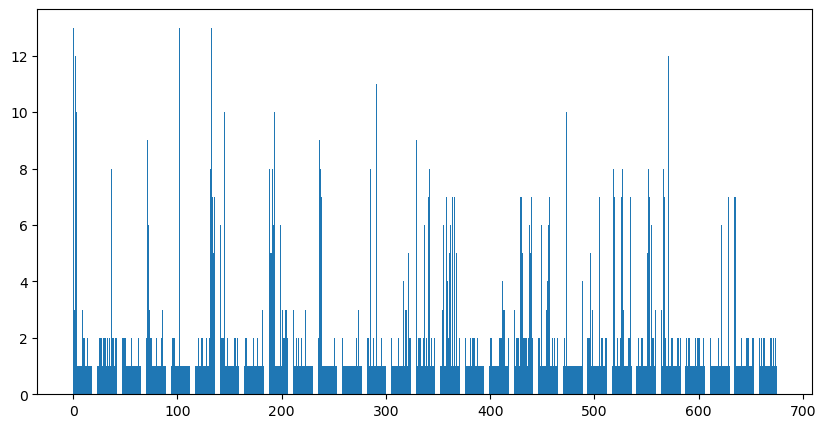

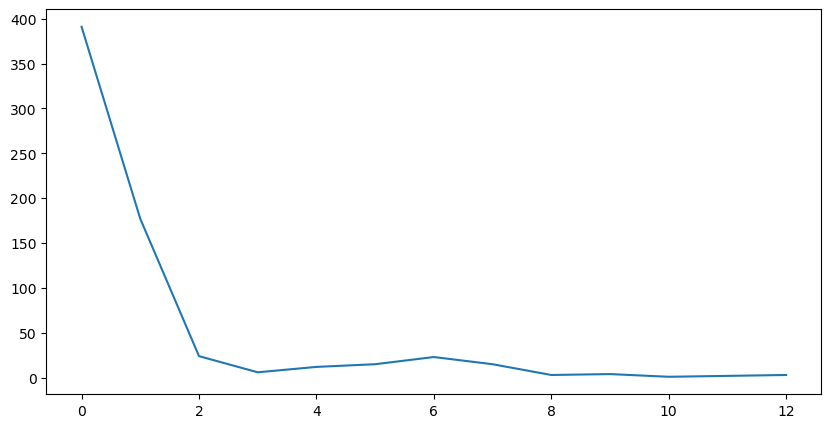

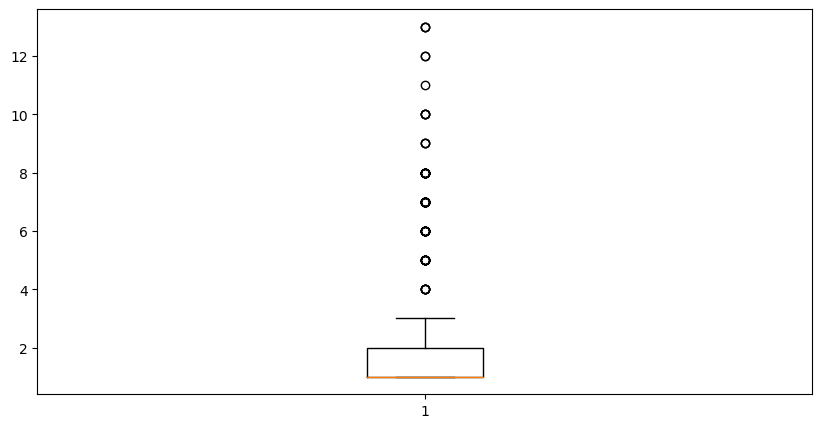

In [48]:
# 打印各mat中主成分数量分布
import matplotlib.pyplot as plt

download_folder_name = 'Tail_652_1'
mat_names = os.listdir(os.path.join(download_save_path, download_folder_name))

plt.figure(figsize=(10, 5))
plt.bar(range(len(mat_names)), PC_num_list)
# plt.xticks(mat_names)
plt.show()

PC_fre_list = [len(np.where(np.array(PC_num_list) == i)[0]) for i in range(1, max(PC_num_list) + 1)]
plt.figure(figsize=(10, 5))
plt.plot(PC_fre_list)
# plt.xticks(mat_names)
plt.show()

plt.figure(figsize=(10, 5))
plt.boxplot(PC_num_list)
plt.show()

In [36]:
for idx in range(163):
    if idx not in non_zeros_cols_list:
        print(find_var_name(idx, var_groups_dict))

('control', 'TCAS')
('control', 'WAI_2')
('control', 'APUF')
('control', 'POVT')
('unclassified', 'VAR_2670')
('unclassified', 'VAR_5107')
('unclassified', 'VAR_6670')
